In [2]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.decomposition import PCA
import math
import scipy.linalg as la
from keras.datasets.mnist import load_data
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance
import numba
from numba import jit, int32, int64, float32, float64

In [3]:
iris = sns.load_dataset('iris')

# matrix data
X = np.array(iris[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']])
specs = np.array(iris['species'])

In [5]:
@jit(nopython = True)
def p_ij(d_matrix, perplexity = 30.0, tol = 1e-5):
    """
    Finds P_ij matrix using binary search to find value of sigma_i

    Inputs: X- np.array of pairwise distance matrix, fixed perplexity

    Output: P-ij matrix
    """
    steps = 10 # maximum number of binary search steps

    (n, d) = d_matrix.shape

    P = np.zeros((n, d), dtype=np.float64)
    beta_sum = 0.0
    log_perp = np.log(perplexity)

    for i in range(n):
        beta_min = -np.inf
        beta_max = np.inf
        beta = 1.0

        # Binary search of precision for i-th conditional distribution
        for j in range(steps):
            sum_Pi = 0.0
            for k in range(d):
                if k != i:
                    P[i, k] = math.exp(-d_matrix[i, k] * beta)
                    sum_Pi += P[i, k]

            sum_disti_Pi = 0.0

            for k in range(d):
                P[i, k] /= sum_Pi
                sum_disti_Pi += d_matrix[i, k] * P[i, k]

            entropy = np.log(sum_Pi) + beta * sum_disti_Pi
            entropy_diff = entropy - log_perp

            if math.fabs(entropy_diff) <= tol:
                break

            if entropy_diff > 0.0:
                beta_min = beta
                if beta_max == np.inf:
                    beta *= 2.0
                else:
                    beta = (beta + beta_max) / 2.0
            else:
                beta_max = beta
                if beta_min == -np.inf:
                    beta /= 2.0
                else:
                    beta = (beta + beta_min) / 2.0

        beta_sum += beta

    return P



# this works alone
@jit(nopython = True)
def squared_euc_dist(X):
    """Calculate squared euclidean distance for all pairs in a data matrix X with d dimensions and n rows. 
    Output is a pairwise distance matrix D that is nxn.
    """
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    
    return D

@jit(nopython = True)
def q_ij(Y):
    """Calculate joint probabilities over all points given Y, the low-dimensional map of data points. (pg. 2585)"""
    
    numerator = np.power(1. + (squared_euc_dist(Y)), -1)
    Q = numerator / np.sum(numerator)
    
    # q_i|i = 0
    np.fill_diagonal(Q, 0.)
    
    return Q

# THIS WORKS
@jit(nopython = True)
def grad_C(P, Q, Y):
    """Estimate the gradient of t-SNE cost with respect to Y."""
    pq_diff = P - Q
    pq_expanded = np.expand_dims(pq_diff, 2)
    y_diffs = np.expand_dims(Y, 1) - np.expand_dims(Y, 0)
    inv_distances = np.power(1 + squared_euc_dist(Y), -1)

    # Expand our inv_distances matrix so can multiply by y_diffs
    distances_expanded = np.expand_dims(inv_distances, 2)

    # Multiply this by inverse distances matrix
    y_diffs_wt = y_diffs * distances_expanded

    # Multiply then sum over j's
    grad = 4. * (pq_expanded * y_diffs_wt).sum(1)
    return grad


@jit(nopython = True)
def tsne_opt(X, num_iters = 1000, perplexity = 30, alpha = 10, momentum = 0.9):
    """Calculate Y, the optimal low-dimensional representation of data matrix X using optimized TSNE.
    
    Inputs: 
        X: data matrix 
        num_iters: number of iterations 
        perplexity: target perplexity for calculating optimal sigmas for P probability matrix
        alpha: learning rate
        momentum: momentum to speed up gradient descent algorithm 
    """

    # Initialize Y 
    np.random.seed(0)
    Y = np.random.normal(0, 0.0001, size=(X.shape[0], 2))
    D = squared_euc_dist(X)
    P = p_ij(D)
    P = P + np.transpose(P)
    P = P / np.sum(P)

    # Initialise past y_t-1 and y_t-2 values (used for momentum)
    Y_tmin2 = Y
    Y_tmin1 = Y

    # gradient descent with momentum
    for i in range(num_iters):

        Q = q_ij(Y)
        grad = grad_C(P, Q, Y)

        # Update Y using momentum (pg. 2587)
        Y = (Y - (alpha * grad)) +  (momentum * (Y_tmin1 - Y_tmin2))
  
        # update values of y_t-1 and y_t-2
        Y_tmin2 = Y_tmin1
        Y_tmin1 = Y

    return Y



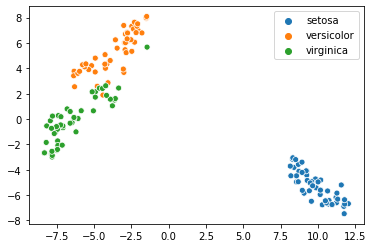

In [6]:
yout = tsne_opt(X)
sns.scatterplot(yout[:,0], yout[:,1], hue = specs)